## Default of Credit Card Clients
## Decision tree type analysis

In [1]:
from joblib import Memory #cache purpose
pwd = "./default/"
cache_dir = pwd + 'cache_dir'
mem = Memory(cache_dir)
output_path = './output/'

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
df_original = pd.read_excel("./input/default of credit card clients.xls",header=1) #rename mal-nomers
df_original =df_original.rename({
                                'PAY_0' : 'PAY_1',
                                'default payment next month':'default'},axis=1)
BILL = [column for column in df_original.columns if 'BILL' in column]
PAY = [column for column in df_original.columns if 'PAY_AMT' in column]                            
rename_dict = {}
for column in BILL+PAY:
    rename_dict[column]=column[:-1]+'_'+column[-1]
df_original = df_original.rename(rename_dict, axis=1)
BILL = [column for column in df_original.columns if 'BILL' in column] #columns with BILL_AMT_n
PAY = [column for column in df_original.columns if 'PAY_AMT' in column]                            
df = df_original.copy()
N_labels = [column for column in df_original.columns if column !='default']
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index , test_index in split.split(df,df.iloc[:,[2,-1]]):
    df_train, label_train= df[N_labels].loc[train_index],df.default[train_index]
    df_test, label_test= df[N_labels].loc[test_index], df.default[test_index]
    
def to_csv(arr,train_or_test='train',name=None):   #to_csv
    df = pd.DataFrame(arr)
    if type(name)==str:
        df.to_csv(f'{output_path}/{name}_{train_or_test}.csv', index = False )
    else:
        df.to_csv(f'{output_path}/{train_or_test}.csv', index = False )

In [2]:
# for train_index , test_index in split.split(df_train,pd.concat([df_train.SEX,label_train],axis=1)):
#     X_train, y_train= df_train.iloc[train_index],label_train.iloc[train_index]
#     X_val, y_val = df_train.iloc[test_index], label_train.iloc[test_index]
#X_train ,y_train= df_train.iloc[:150,:] ,label_train.iloc[:150]
X_train ,y_train= df_train,label_train
#X,y= df_train.iloc[:300,:] ,label_train.iloc[:300]

In [3]:
from pyts.transformation import BagOfPatterns as BOP
from mods_defaults import ElementaryExtractor,BasicTransformer,MyMulPyts, NonTsPass #for pickle (cache)purpose
my_basic = BasicTransformer()
t_df = my_basic.fit_transform(X_train)
print(t_df.columns)

Index(['log_LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'log_BILL_AMT_1',
       'log_BILL_AMT_2', 'log_BILL_AMT_3', 'log_BILL_AMT_4', 'log_BILL_AMT_5',
       'log_BILL_AMT_6', 'log_PAY_AMT_1', 'log_PAY_AMT_2', 'log_PAY_AMT_3',
       'log_PAY_AMT_4', 'log_PAY_AMT_5', 'log_PAY_AMT_6', 'log_USAGE_1',
       'log_USAGE_2', 'log_USAGE_3', 'log_USAGE_4', 'log_USAGE_5',
       'log_DIFF_0', 'log_DIFF_1', 'log_DIFF_2', 'log_DIFF_3', 'log_DIFF_4'],
      dtype='object')


In [4]:
D_PAY = ['PAY_'+str(i) for i in range(1,7)]
L_PAY = [column for column in t_df.columns if 'log_PAY' in column]
L_BILL = [column for column in t_df.columns if 'log_BILL' in column]
L_USAGE =  [column for column in t_df.columns if 'log_USAGE' in column]
L_DIFF =  [column for column in t_df.columns if 'log_DIFF' in column]
print(len(L_PAY))

6


In [5]:
from sklearn.pipeline import Pipeline
# SVCs
# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# pipeline
from sklearn.pipeline import make_union
# evaluation modules
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
def pre_rec_score(y_train,y_pred):
    pre_score = precision_score(y_train,y_pred)
    print(f'precision : {pre_score}')
    rec_score = recall_score(y_train,y_pred)
    print(f'recall : {rec_score}')
    f_score = f1_score(y_train,y_pred)
    print(f'f1_score: {f_score}')



In [6]:
length_5_bop =MyMulPyts(estimator=BOP(window_size=3,
                                    word_size=3,
                                    n_bins=3,
                                    sparse=False,
                                    strategy='uniform'),
                          flatten=False,
                          channel_list=[L_USAGE,L_DIFF] )
length_6_bop =MyMulPyts( estimator=BOP(window_size=3,
                                        word_size=3,
                                        sparse=False,
                                        n_bins=3,
                                        strategy='uniform'),
                          flatten=False ,
                          channel_list=[D_PAY,L_PAY,L_BILL])
my_elementary_trans_6 = ElementaryExtractor([D_PAY,L_PAY,L_BILL])
my_elementary_trans_5 = ElementaryExtractor([L_USAGE,L_DIFF])

extractors = [NonTsPass(),length_5_bop,length_6_bop,my_elementary_trans_5,my_elementary_trans_6]
#extractors = [my_elementary_trans_5,my_elementary_trans_6]
extractor = make_union(*extractors)
extractor

FeatureUnion(transformer_list=[('nontspass', NonTsPass()),
                               ('mymulpyts-1',
                                MyMulPyts(channel_list=[['log_USAGE_1',
                                                         'log_USAGE_2',
                                                         'log_USAGE_3',
                                                         'log_USAGE_4',
                                                         'log_USAGE_5'],
                                                        ['log_DIFF_0',
                                                         'log_DIFF_1',
                                                         'log_DIFF_2',
                                                         'log_DIFF_3',
                                                         'log_DIFF_4']],
                                          estimator=BagOfPatterns(n_bins=3,
                                                                  sparse=False,
                                                                  strategy='uniform',
                                                                  window_size=3,
                                                                  word_size=3),
                                          flatten=False)),
                               ('mymu...
                                                                   'log_DIFF_2',
                                                                   'log_DIFF_3',
                                                                   'log_DIFF_4']])),
                               ('elementaryextractor-2',
                                ElementaryExtractor(channel_list=[['PAY_1',
                                                                   'PAY_2',
                                                                   'PAY_3',
                                                                   'PAY_4',
                                                                   'PAY_5',
                                                                   'PAY_6'],
                                                                  ['log_PAY_AMT_1',
                                                                   'log_PAY_AMT_2',
                                                                   'log_PAY_AMT_3',
                                                                   'log_PAY_AMT_4',
                                                                   'log_PAY_AMT_5',
                                                                   'log_PAY_AMT_6'],
                                                                  ['log_BILL_AMT_1',
                                                                   'log_BILL_AMT_2',
                                                                   'log_BILL_AMT_3',
                                                                   'log_BILL_AMT_4',
                                                                   'log_BILL_AMT_5',
                                                                   'log_BILL_AMT_6']]))])

In [11]:
extractor.get_params()

{'n_jobs': None,
 'transformer_list': [('nontspass', NonTsPass()),
  ('mymulpyts-1',
   MyMulPyts(channel_list=[['log_USAGE_1', 'log_USAGE_2', 'log_USAGE_3',
                            'log_USAGE_4', 'log_USAGE_5'],
                           ['log_DIFF_0', 'log_DIFF_1', 'log_DIFF_2', 'log_DIFF_3',
                            'log_DIFF_4']],
             estimator=BagOfPatterns(n_bins=5, sparse=False, strategy='uniform',
                                     window_size=3, word_size=3),
             flatten=False)),
  ('mymulpyts-2',
   MyMulPyts(channel_list=[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],
                           ['log_PAY_AMT_1', 'log_PAY_AMT_2', 'log_PAY_AMT_3',
                            'log_PAY_AMT_4', 'log_PAY_AMT_5', 'log_PAY_AMT_6'],
                           ['log_BILL_AMT_1', 'log_BILL_AMT_2', 'log_BILL_AMT_3',
                            'log_BILL_AMT_4', 'log_BILL_AMT_5',
                            'log_BILL_AMT_6']],
             estimator=B

In [17]:
#  pipe = Pipeline([('base',BasicTransformer()),
#                 ('extractor',extractor),
#                 ('scaler',StandardScaler()),
#                 ('estimator',LinearSVC(max_iter = 10000,random_state=42))
#                 ],memory = cache_dir)
# pipe.fit(X_train,y_train)
# y_pred = pipe.predict(X_train)
# cf_matrix =confusion_matrix(y_train,y_pred)
# print(cf_matrix)
# pre_rec_score(y_train,y_pred)

In [10]:
from sklearn.model_selection import GridSearchCV
my_base_transform = BasicTransformer()
clfs = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=200,random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]

In [ ]:
f_pipe = Pipeline()

In [11]:
pipe_transform = Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

In [13]:
pipe_transform

Pipeline(memory='./default/cache_dir',
         steps=[('base', BasicTransformer()),
                ('extractor',
                 FeatureUnion(transformer_list=[('nontspass', NonTsPass()),
                                                ('mymulpyts-1',
                                                 MyMulPyts(channel_list=[['log_USAGE_1',
                                                                          'log_USAGE_2',
                                                                          'log_USAGE_3',
                                                                          'log_USAGE_4',
                                                                          'log_USAGE_5'],
                                                                         ['log_DIFF_0',
                                                                          'log_DIFF_1',
                                                                          'log_DIFF_2',
                                                                          'log_DIFF_3',
                                                                          'log_DIFF_4']],
                                                           estimator=BagOfPatterns(n_bi...
                                                                                    'log_DIFF_2',
                                                                                    'log_DIFF_3',
                                                                                    'log_DIFF_4']])),
                                                ('elementaryextractor-2',
                                                 ElementaryExtractor(channel_list=[['PAY_1',
                                                                                    'PAY_2',
                                                                                    'PAY_3',
                                                                                    'PAY_4',
                                                                                    'PAY_5',
                                                                                    'PAY_6'],
                                                                                   ['log_PAY_AMT_1',
                                                                                    'log_PAY_AMT_2',
                                                                                    'log_PAY_AMT_3',
                                                                                    'log_PAY_AMT_4',
                                                                                    'log_PAY_AMT_5',
                                                                                    'log_PAY_AMT_6'],
                                                                                   ['log_BILL_AMT_1',
                                                                                    'log_BILL_AMT_2',
                                                                                    'log_BILL_AMT_3',
                                                                                    'log_BILL_AMT_4',
                                                                                    'log_BILL_AMT_5',
                                                                                    'log_BILL_AMT_6']]))]))])

In [14]:
pipe_transform.fit(X_train)

Pipeline(memory='./default/cache_dir',
         steps=[('base', BasicTransformer()),
                ('extractor',
                 FeatureUnion(transformer_list=[('nontspass', NonTsPass()),
                                                ('mymulpyts-1',
                                                 MyMulPyts(channel_list=[['log_USAGE_1',
                                                                          'log_USAGE_2',
                                                                          'log_USAGE_3',
                                                                          'log_USAGE_4',
                                                                          'log_USAGE_5'],
                                                                         ['log_DIFF_0',
                                                                          'log_DIFF_1',
                                                                          'log_DIFF_2',
                                                                          'log_DIFF_3',
                                                                          'log_DIFF_4']],
                                                           estimator=BagOfPatterns(n_bi...
                                                                                    'log_DIFF_2',
                                                                                    'log_DIFF_3',
                                                                                    'log_DIFF_4']])),
                                                ('elementaryextractor-2',
                                                 ElementaryExtractor(channel_list=[['PAY_1',
                                                                                    'PAY_2',
                                                                                    'PAY_3',
                                                                                    'PAY_4',
                                                                                    'PAY_5',
                                                                                    'PAY_6'],
                                                                                   ['log_PAY_AMT_1',
                                                                                    'log_PAY_AMT_2',
                                                                                    'log_PAY_AMT_3',
                                                                                    'log_PAY_AMT_4',
                                                                                    'log_PAY_AMT_5',
                                                                                    'log_PAY_AMT_6'],
                                                                                   ['log_BILL_AMT_1',
                                                                                    'log_BILL_AMT_2',
                                                                                    'log_BILL_AMT_3',
                                                                                    'log_BILL_AMT_4',
                                                                                    'log_BILL_AMT_5',
                                                                                    'log_BILL_AMT_6']]))]))])

In [15]:
pipe = Pipeline([pipe_transform,
                DecisionTreeClassifier()])

In [16]:
for clf in clfs:
    pipe = Pipeline([pipe_transform,
                    clf])
    pipe.fit(X_train,y_train):
    y_pred = pipe.predict(X_train)
    cf_matrix =confusion_matrix(y_train,y_pred)
    print(cf_matrix)
    pre_rec_score(y_train,y_pred)

TypeError: cannot unpack non-iterable DecisionTreeClassifier object

In [23]:
pipe.get_params()

{'memory': './default/cache_dir',
 'steps': [('base', BasicTransformer()),
  ('extractor',
   FeatureUnion(transformer_list=[('nontspass', NonTsPass()),
                                  ('mymulpyts-1',
                                   MyMulPyts(channel_list=[['log_USAGE_1',
                                                            'log_USAGE_2',
                                                            'log_USAGE_3',
                                                            'log_USAGE_4',
                                                            'log_USAGE_5'],
                                                           ['log_DIFF_0',
                                                            'log_DIFF_1',
                                                            'log_DIFF_2',
                                                            'log_DIFF_3',
                                                            'log_DIFF_4']],
                                             esti

### Grid searching pipeline

In [ ]:
param_grid = {
    'est__C':[0.0005,0.001,0.01,0.1,0.4,0.8,1.0],
    #'est__kernel' : ['linear','poly','rbf','sigmoid'],
    'est__kernel' : ['sigmoid'],
    'est__gamma' : ['scale']
}
search = GridSearchCV(pipe, 
                      scoring='recall',
                      param_grid=param_grid,
                      error_score='raise',
                      n_jobs=2)
search.fit(X_train,y_train)
print(f'cv results = {search.cv_results_}')
print('\n')
print(f'best estimator = {search.best_estimator_}')
print('\n')
print(f'best score = {search.best_score_}')
print('\n')
print(f'best parameter = {search.best_params_}')
print('\n')
y_pred = search.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
print('\n')
pre_rec_score(y_train,y_pred)

### train-val analysis on best estimator

In [7]:
for train_index , test_index in split.split(df_train,pd.concat([df_train.SEX,label_train],axis=1)):
    X_train, y_train= df_train.iloc[train_index],label_train.iloc[train_index]
    X_val, y_val = df_train.iloc[test_index], label_train.iloc[test_index]

function for graphing

In [8]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=None):
    if ax is None:
        plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
        plt.plot(thresholds, recalls[:-1], 'g-',label="recall")
        plt.xlabel("thresholds")
        plt.legend(loc="upper left")
        plt.ylim([0,1])
    else:
        ax.plot(thresholds, precisions[:-1], 'b--', label="Precision")
        ax.plot(thresholds, recalls[:-1], 'g-',label="recall")
        ax.set_xlabel("thresholds")
        ax.legend(loc="upper left")
        ax.set_ylim([0,1])


## With best estimator :fit, predict and save result as csv

In [ ]:

my_pipe=search.best_estimator_
my_pipe.fit(X_train,y_train)
train_pred =my_pipe.predict(X_train)
#train_prob = my_pipe.predict_proba(X_train)
val_pred =my_pipe.predict(X_val)
#val_prob = my_pipe.predict_proba(X_val)
y_score = my_pipe.decision_function(X_val)
to_csv(train_pred,'train','pred')
#to_csv(train_prob,'train','prob')
to_csv(val_pred,'val','pred')
#to_csv(val_prob,'val','prob')
to_csv(y_score,'val','decision')

## manually put best estimator : fit,predict and save result

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
my_base_transform = BasicTransformer()
my_scaler = StandardScaler()
my_SVC = SVC(**{'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'},random_state = 42)

k_type ='sigmoid'
my_pipe= Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ('scaler',my_scaler),
                ('est',my_SVC)
                ],memory=cache_dir)
my_pipe.fit(X_train,y_train)
train_pred =my_pipe.predict(X_train)
#train_prob = my_pipe.predict_proba(X_train)
val_pred =my_pipe.predict(X_val)
#val_prob = my_pipe.predict_proba(X_val)
y_score = my_pipe.decision_function(X_val)
to_csv(train_pred,f'train','SVC_time/{k_type}/pred')
#to_csv(train_prob,'train','prob')
to_csv(val_pred,f'val','SVC_time/{k_type}/pred')
#to_csv(val_prob,'val','prob')
to_csv(y_score,'val','SVC_time/{k_type}/decision')

# Sigmoid error analysis

SVC_time sigmoid
[[11501  1641]
 [ 2380  1353]]
[[3823  558]
 [ 800  444]]


train_score
precision : 0.45190380761523047
recall : 0.3624430752745781
f1_score: 0.40225955106288086

 val score
precision : 0.4431137724550898
recall : 0.35691318327974275
f1_score: 0.39536954585930545


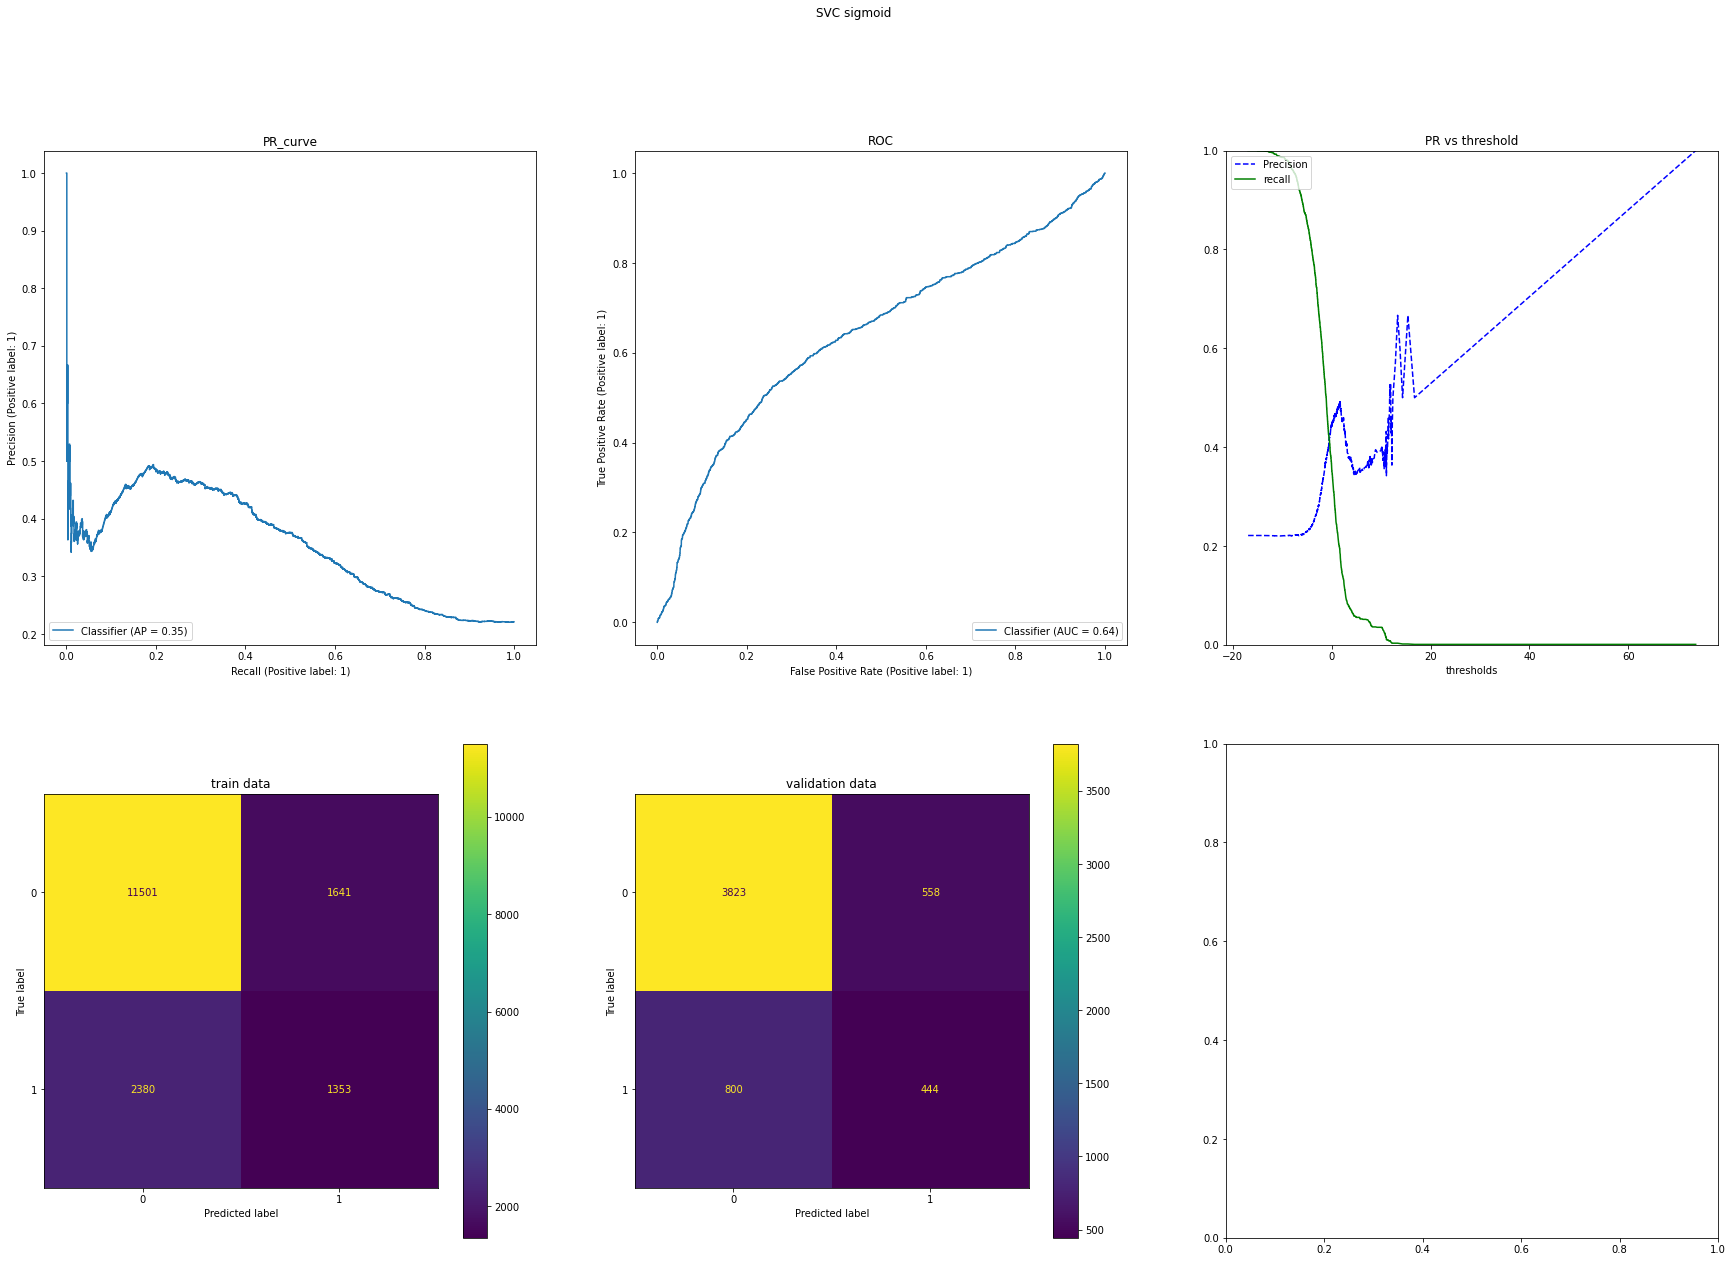

In [12]:
k_type ='sigmoid'
fig, axes = plt.subplots(2,3,figsize=(30,20))
address=f'C:/Users/sean/Documents/git/221117_MLBasic/SW/output/SVC_time/{k_type}/bop/'
train_pred = pd.read_csv(address+'pred_train.csv').to_numpy()
val_pred = pd.read_csv(address+'pred_val.csv').to_numpy()
y_score = pd.read_csv(address+'decision_val.csv').to_numpy()


cf_matrix_t =confusion_matrix(y_train,train_pred)
print(f'SVC_time {k_type}')
print(cf_matrix_t)
cf_matrix_v =confusion_matrix(y_val,val_pred)
print(cf_matrix_v)
print('\n')
print('train_score')
pre_rec_score(y_train,train_pred)
print('\n val score')
pre_rec_score(y_val,val_pred)

RocCurveDisplay.from_predictions(y_val,y_score,ax=axes[0,1])
display = PrecisionRecallDisplay.from_predictions(y_val,y_score,ax=axes[0,0])
# display.plot(ax=axes[0,0])
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(ax=axes[1,0])
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(ax=axes[1,1])
axes[0,1].set_title('ROC')
axes[0,0].set_title('PR_curve')
axes[1,0].set_title('train data')
axes[1,1].set_title('validation data')
precisions , recalls , thresholds = precision_recall_curve(y_val, y_score)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
axes[0,2].set_title('PR vs threshold')
fig.suptitle(f'SVC {k_type}')
plt.show()
plt.close()

# RBF

## Manual best estimator

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
my_base_transform = BasicTransformer()
my_scaler = StandardScaler()
my_SVC = SVC(**{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},random_state = 42)

k_type ='rbf'
my_pipe= Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ('scaler',my_scaler),
                ('est',my_SVC)
                ],memory=cache_dir)
my_pipe.fit(X_train,y_train)
train_pred =my_pipe.predict(X_train)
#train_prob = my_pipe.predict_proba(X_train)
val_pred =my_pipe.predict(X_val)
#val_prob = my_pipe.predict_proba(X_val)
y_score = my_pipe.decision_function(X_val)


to_csv(train_pred,f'train',f'SVC_time/{k_type}/pred')
#to_csv(train_prob,'train','prob')
to_csv(val_pred,f'val',f'SVC_time/{k_type}/pred')
#to_csv(val_prob,'val','prob')
to_csv(y_score,'val',f'SVC_time/{k_type}/decision')

# RBF error analysis

SVC_time rbf
[[12670   472]
 [ 2307  1426]]
[[4173  208]
 [ 840  404]]


train_score
precision : 0.7513171759747103
recall : 0.38199839271363517
f1_score: 0.5064819747824543

 val score
precision : 0.6601307189542484
recall : 0.3247588424437299
f1_score: 0.4353448275862069


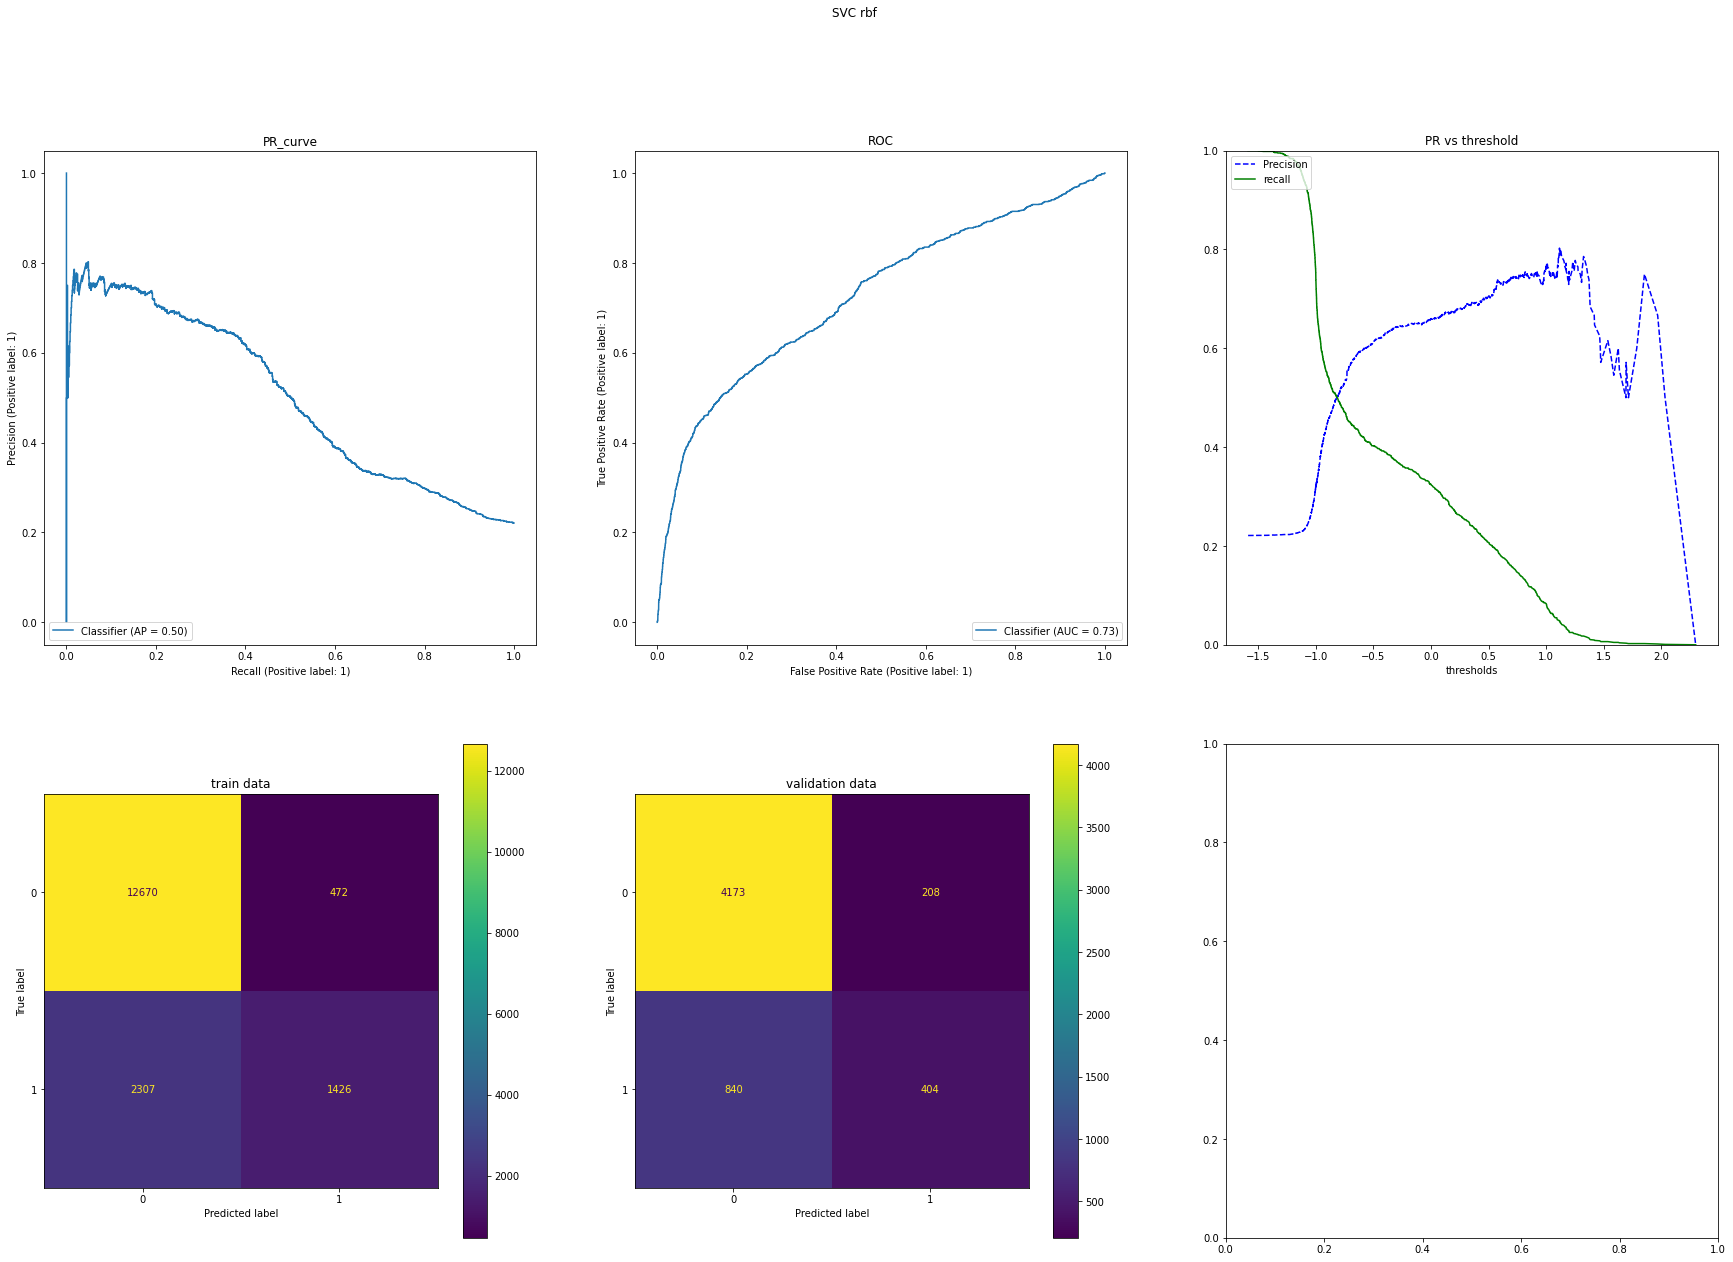

In [13]:
k_type = 'rbf'
fig, axes = plt.subplots(2,3,figsize=(30,20))
address=f'C:/Users/sean/Documents/git/221117_MLBasic/SW/output/SVC_time/{k_type}/bop/'
train_pred = pd.read_csv(address+'pred_train.csv').to_numpy()
val_pred = pd.read_csv(address+'pred_val.csv').to_numpy()
y_score = pd.read_csv(address+'decision_val.csv').to_numpy()

print(f'SVC_time {k_type}')
cf_matrix_t =confusion_matrix(y_train,train_pred)
print(cf_matrix_t)
cf_matrix_v =confusion_matrix(y_val,val_pred)
print(cf_matrix_v)
print('\n')
print('train_score')
pre_rec_score(y_train,train_pred)
print('\n val score')
pre_rec_score(y_val,val_pred)

RocCurveDisplay.from_predictions(y_val,y_score,ax=axes[0,1])
display = PrecisionRecallDisplay.from_predictions(y_val,y_score,ax=axes[0,0])
# display.plot(ax=axes[0,0])
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(ax=axes[1,0])
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(ax=axes[1,1])
axes[0,1].set_title('ROC')
axes[0,0].set_title('PR_curve')
axes[1,0].set_title('train data')
axes[1,1].set_title('validation data')
precisions , recalls , thresholds = precision_recall_curve(y_val, y_score)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
axes[0,2].set_title('PR vs threshold')
fig.suptitle(f'SVC {k_type}')
plt.show()
plt.close()